<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/cnn.png" width="350">


Colab: [**exercises**](https://colab.research.google.com/drive/1HFsebBH7SJ7wqVCmTAt097FkDbCC6AQf) | [**solutions**](https://colab.research.google.com/drive/1ttKR6WOCKDBXmbwvKd-gpI2AUXp1OzBa)

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-la82367/shared_invite/zt-1uvoagohe-JUv9xB7Vr143pdx1UBPrzQ), and ask any questions on the dedicated channels for this chapter of material.


# [0.2] - `as_strided`, Convolutions and CNNs


## Introduction


This section is designed to get you familiar with basic neural networks: how they are structured, the basic operations like linear layers and convolutions which go into making them, and why they work as well as they do. You'll be using libraries like `einops`, and functions like `torch.as_strided` to get a very low-level picture of how these operations work, which will help build up your overall understanding.

Note that `torch.as_strided` isn't something which will come up explicitly in much of the rest of the course (unlike `einops`). The purpose of the stride exercises is more to give you an appreciation for what's going on under the hood, so that we can build layers of abstraction on top of that during the rest of this week (and by extension this course). I see this as analogous to how [many CS courses](https://cs50.harvard.edu/x/2023/) start by teaching you about languages like C and concepts like pointers and memory management before moving on to higher-level langauges like Python which abstract away these details. The hope is that when you get to the later sections of the course, you'll have the tools to understand them better.


## Content & Learning Objectives


### 1️⃣ Einops and Einsum

In part 1, we'll go through some basic `einops` and `einsum` exercises. These are designed to get you comfortable with using Einstein summation convention, and why it's useful in tensors. 

> ##### Learning objectives
> 
> - Understand the basics of Einstein summation convention
> - Learn how to use `einops` to perform basic tensor rearrangement, and `einsum` to to perform standard linear algebra operations on tensors

### 2️⃣ Array strides

`as_strided` is a low-level array method that forces you to engage with the messy details of linear operations like matrix multiplictions and convolutions. Although you probably won't need to use them on a regular basis, they will form an essential part of your toolbox as you build up a neural network from scratch.

> ##### Learning objectives
> 
> - Understand how array strides work, and why they're important for efficient linear operations
> - Learn how to use `as_strided` to perform simple linear operations like trace and matrix multiplication

### 3️⃣ Convolutions

Convolutions are a vital part of image classifiers. In part 3, has you write your own functions to perform 1D and 2D convolutions, using your knowledge of `einsum` and `as_strided` from previous sections. This section contains some of the hardest exercises, so if you get stuck then you should be willing to move on to section 4 (which is probably the most important of today's sections).

> ##### Learning objectives
>
> - Understand how convolutions work, and how they're used in neural networks
> - Learn how to use the tools of the last two sections to perform 1D and 2D convolutions

### 4️⃣ Making your own modules

In part 4, we start on some of the exercises that will be built on in day 3. We'll be taking our functions from sections 2 & 3, and using them to create modules which inherit from PyTorch's `nn.Module`. 

> ##### Learning objectives
>
> - Learn how to create your own modules in PyTorch, by inheriting from `nn.Module`
> - Assemble the pieces together to create a simple convolutional neural network, to classify MNIST digits


## Setup (don't read, just run!)


In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter0_fundamentals"):
        !wget https://github.com/callummcdougall/ARENA_2.0/archive/refs/heads/main.zip
        !unzip /content/main.zip 'ARENA_2.0-main/chapter0_fundamentals/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter0_fundamentals/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter0_fundamentals", "chapter0_fundamentals")
        os.rmdir("ARENA_2.0-main")
        os.chdir("chapter0_fundamentals/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Things that need to be done manually

# Nothing

# END

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13

--2023-06-05 15:51:45--  https://github.com/callummcdougall/ARENA_2.0/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main [following]
--2023-06-05 15:51:45--  https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [     <=>            ]  25.95M  11.4MB/s    in 2.3s    

2023-06-05 15:51:48 (11.4 MB/s) - ‘main.zip’ saved [27207143]

Archive:  /content/main.zip
3d7e3e17ac08ed26df059fa612efa90b49f9b6ba
   creating: ARENA_2.0-main/chapter0_fundamentals/exercise

In [2]:
import os
import sys
import numpy as np
import einops
from typing import Union, Optional, Tuple
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float
import functools
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm

# Make sure exercises are in the path
chapter = r"chapter0_fundamentals"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part2_cnns"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, bar
from part2_cnns.utils import display_array_as_img, display_soln_array_as_img
import part2_cnns.tests as tests

MAIN = __name__ == "__main__"

# 1️⃣ Einops and Einsum


> ### Learning objectives
> 
> - Understand the basics of Einstein summation convention
> - Learn how to use `einops` to perform basic tensor rearrangement, and `einsum` to to perform standard linear algebra operations on tensors


## Reading

* Read about the benefits of the `einops` library [here](https://www.blopig.com/blog/2022/05/einops-powerful-library-for-tensor-operations-in-deep-learning/).
* If you haven't already, then review the [Einops basics tutorial](https://einops.rocks/1-einops-basics/) (up to the "fancy examples" section).
* Read [einsum is all you need](https://rockt.github.io/2018/04/30/einsum) (or [watch it](https://www.youtube.com/watch?v=pkVwUVEHmfI)) for a brief overview of the `einsum` function and how it works. (You don't need to read past section 2.10.)


In [41]:
ims = t.rand(6,96,6,3)
print(ims.shape)
ims4 = einops.rearrange(ims, 'b h w c -> h (b w) c')
print(ims4.shape)
ims2 = einops.rearrange(ims, 'b h (w w2) c -> (h w2) (b w) c', w2=2)
print(ims2.shape)
ims3 = einops.rearrange(ims, 'b (h h2) w c -> h (b w h2) c', h2=2)
print(ims3.shape)

torch.Size([6, 96, 6, 3])
torch.Size([96, 36, 3])
torch.Size([192, 18, 3])
torch.Size([48, 72, 3])


## Einops


In [42]:
arr = np.load(section_dir / "numbers.npy") # n c h w
print(arr.shape)

(6, 3, 150, 150)


`arr` is a 4D numpy array. The first axes corresponds to the number, and the next three axes are channels (i.e. RGB), height and width respectively. You have the function `utils.display_array_as_img` which takes in a numpy array and displays it as an image. There are two possible ways this function can be run:

* If the input is three-dimensional, the dimensions are interpreted as `(channel, height, width)` - in other words, as an RGB image.
* If the input is two-dimensional, the dimensions are interpreted as `(height, width)` - i.e. a monochrome image.

For example:



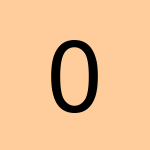

In [43]:
display_array_as_img(arr[0])

A series of images follow below, which have been created using `einops` functions performed on `arr`. You should work through these and try to produce each of the images yourself. This page also includes solutions, but you should only look at them after you've tried for at least five minutes.

> *Note - if you find you're comfortable with the first ~half of these, you can skip to later sections if you'd prefer, since these aren't particularly conceptually important.*


### Einops exercises

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠🟠⚪⚪

You should spend up to ~45 minutes on these exercises collectively.

If you think you get the general idea, then you can skip to the next section.
```


#### Exercise 1



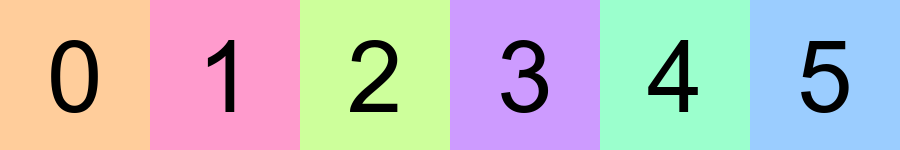

In [44]:
display_soln_array_as_img(1)


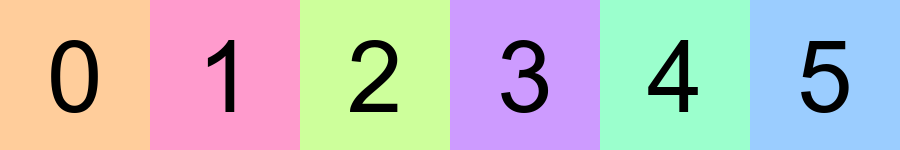

In [45]:
arr1 = einops.rearrange(arr,'n c h w -> c h (n w)')
display_array_as_img(arr1)

<details>
<summary>Solution </summary>

```python
arr1 = einops.rearrange(arr, "b c h w -> c h (b w)")
```
</details>


---


#### Exercise 2



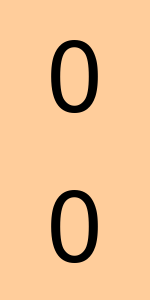

In [46]:
display_soln_array_as_img(2)


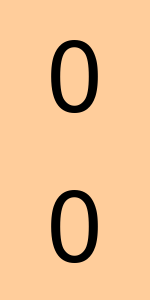

In [47]:
arr2 = einops.repeat(arr[0],'c h w -> c (2 h) w')
display_array_as_img(arr2)

<details>
<summary>Solution </summary>

```python
arr2 = einops.repeat(arr[0], "c h w -> c (2 h) w")
```
</details>


---


#### Exercise 3



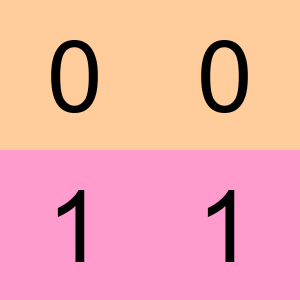

In [48]:
display_soln_array_as_img(3)


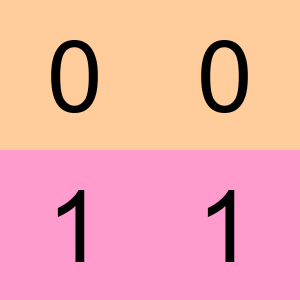

In [49]:
arr3 = einops.repeat(arr[:2],'n c h w -> c (n h) (2 w)')
display_array_as_img(arr3)

<details>
<summary>Solution </summary>

```python
arr3 = einops.repeat(arr[0:2], "b c h w -> c (b h) (2 w)")
```
</details>


---


#### Exercise 4



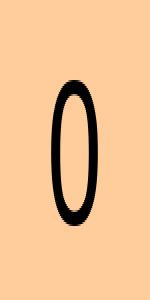

In [50]:
display_soln_array_as_img(4)


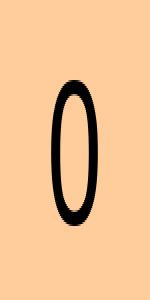

In [51]:
arr4 = einops.repeat(arr[0],'c h w -> c (h 2) w')
display_array_as_img(arr4)

<details>
<summary>Solution </summary>

```python
arr4 = einops.repeat(arr[0], "c h w -> c (h 2) w")
```
</details>


---


#### Exercise 5


In [52]:
display_soln_array_as_img(5)

In [53]:
arr5 = einops.rearrange(arr[0], 'c h w -> h (c w)')
display_array_as_img(arr5)

<details>
<summary>Solution </summary>

```python
arr5 = einops.rearrange(arr[0], "c h w -> h (c w)")
```
</details>


---


#### Exercise 6



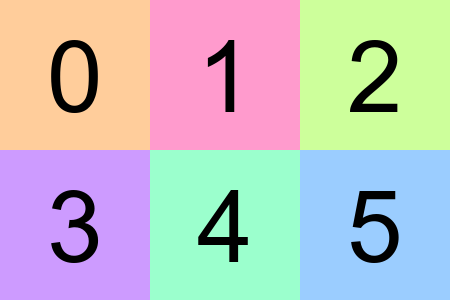

In [54]:
display_soln_array_as_img(6)


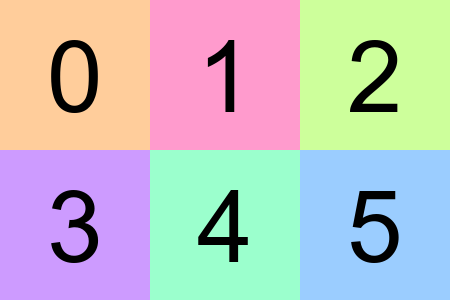

In [55]:
arr6 = einops.rearrange(arr,'(n1 n2) c h w -> c (n1 h) (n2 w)',n1 = 2)
display_array_as_img(arr6)

<details>
<summary>Solution </summary>

```python
arr6 = einops.rearrange(arr, "(b1 b2) c h w -> c (b1 h) (b2 w)", b1=2)
```
</details>


---


#### Exercise 7


In [56]:
display_soln_array_as_img(7)

In [57]:
arr7 = einops.reduce(arr,'n c h w -> h (n w)','max')
display_array_as_img(arr7)

<details>
<summary>Solution </summary>

```python
arr7 = einops.reduce(arr.astype(float), "b c h w -> h (b w)", "max").astype(int)
```
</details>


---


#### Exercise 8


In [58]:
display_soln_array_as_img(8)

In [59]:
arr8 = einops.reduce(arr,'n c h w -> h w','min')
display_array_as_img(arr8)

<details>
<summary>Solution </summary>

```python
arr8 = einops.reduce(arr.astype(float), "b c h w -> h w", "min").astype(int)
```
</details>


---


#### Exercise 9



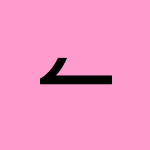

In [60]:
display_soln_array_as_img(9)


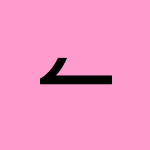

In [61]:
arr9 = einops.rearrange(arr[1],'c h w -> c w h')
display_array_as_img(arr9)

<details>
<summary>Solution </summary>

```python
arr9 = einops.rearrange(arr[1], "c h w -> c w h")
```
</details>


---


#### Exercise 10



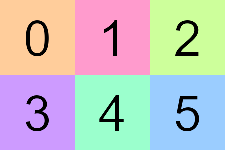

In [62]:
display_soln_array_as_img(10)


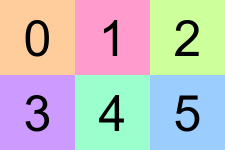

In [63]:
arr10 = einops.reduce(arr.astype(float),'(n1 n2) c (h1 h2) (w1 w2) -> c (n1 h1) (n2 w1)','mean',n1=2, h2=2, w2=2)
display_array_as_img(arr10)

<details>
<summary>Solution </summary>

```python
arr10 = einops.reduce(arr, "(b1 b2) c (h h2) (w w2) -> c (b1 h) (b2 w)", "max", h2=2, w2=2, b1=2)
```
</details>


## Einsum

Einsum is a very useful function for performing linear operations, which you'll probably be using a lot during this programme.

> Note - we'll be using the `einops.einsum` version of the function, which works differently to the more conventional `torch.einsum`:
> 
> * `einops.einsum` has the arrays as the first arguments, and uses spaces to separate dimensions in the string.
> * `torch.einsum` has the string as its first argument, and doesn't use spaces to separate dimensions (each dim is represented by a single character).
> 
> For instance, `torch.einsum("ij,i->j", A, b)` is equivalent to `einops.einsum(A, b, "i j, i -> j")`. (Note, einops doesn't care whether there are spaces either side of `,` and `->`, so you don't need to match this syntax exactly.)

Although there are many different kinds of operations you can perform, they are all derived from three key rules:

1. Repeating letters in different inputs means those values will be multiplied, and those products will be in the output. 
    * For example, `M = einops.einsum(A, B, "i j, i j -> i j")` just corresponds to the elementwise product `M = A * B` (because $M_{ij} = A_{ij} B_{ij}$).
2. Omitting a letter means that the axis will be summed over.
    * For example, if `x` is a 2D array with shape `(I, J)`, then `einops.einsum(x, "i j -> i")` will be a 1D array of length `I` containing the row sums of `x` (we're summing along the `j`-index, i.e. across rows).
3. We can return the unsummed axes in any order.
    * For example, `einops.einsum(x, "i j k -> k j i")` does the same thing as `einops.rearrange(x, "i j k -> k j i")`.

*Note - the einops creators supposedly have plans to support shape rearrangement, e.g. with operations like `einops.einsum(x, y, "i j, j k l -> i (k l)")` (i.e. combining the features of rearrange and einsum), so we can all look forward to that day!*


### Einsum exercises

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠🟠🟠⚪

You should spend up to 15-20 minutes on these exercises collectively.

If you think you get the general idea, then you can skip to the next section.
```

In the following exercises, you'll write simple functions using `einsum` which replicate the functionality of standard NumPy functions: trace, matrix multiplication, inner and outer products. We've also included some test functions which you should run.

Note - this version of einsum will require that you include `->`, even if you're summing to a scalar (i.e. the right hand side of your string expression is empty).


In [64]:
def einsum_trace(mat: np.ndarray):
    '''
    Returns the same as `np.trace`.
    '''
    return einops.einsum(mat,'i i -> ')

def einsum_mv(mat: np.ndarray, vec: np.ndarray):
    '''
    Returns the same as `np.matmul`, when `mat` is a 2D array and `vec` is 1D.
    '''
    return einops.einsum(mat,vec,'i j, j -> i')

def einsum_mm(mat1: np.ndarray, mat2: np.ndarray):
    '''
    Returns the same as `np.matmul`, when `mat1` and `mat2` are both 2D arrays.
    '''
    return einops.einsum(mat1,mat2,'i j, j k -> i k')

def einsum_inner(vec1: np.ndarray, vec2: np.ndarray):
    '''
    Returns the same as `np.inner`.
    '''
    return einops.einsum(vec1,vec2,'i,i -> ')

def einsum_outer(vec1: np.ndarray, vec2: np.ndarray):
    '''
    Returns the same as `np.outer`.
    '''
    return einops.einsum(vec1,vec2,'i,j -> i j')

tests.test_einsum_trace(einsum_trace)
tests.test_einsum_mv(einsum_mv)
tests.test_einsum_mm(einsum_mm)
tests.test_einsum_inner(einsum_inner)
tests.test_einsum_outer(einsum_outer)

All tests in `test_einsum_trace` passed!
All tests in `test_einsum_mv` passed!
All tests in `test_einsum_mm` passed!
All tests in `test_einsum_inner` passed!
All tests in `test_einsum_outer` passed!




<details>
<summary>Help - I get <code>ImportError: numpy.core.multiarray failed to import</code></summary>

This is an annoying colab-related error which I haven't been able to find a satisfying fix for. The setup code at the top of this notebook should have installed a version of numpy which works, although you'll have to click "Restart Runtime" (from the Runtime menu) to make this work. Make sure you don't re-run the cell with `pip install`s. 

If this still doesn't work, please reach out to me at `callum@arena.education`.
</details>


<details>
<summary>Help - I get 'TypeError: cannot use a string pattern on a bytes-like object'</summary>

This is probably because you have strings and arrays the wrong way round. In `einsum`, the string goes first and the arrays follow. This is because `einsum` accepts a variable number of arrays but only one string. `einops` functions only work on single arrays, so the array is the first argument for those functions.
</details>

<details>
<summary>Solution</summary>


```python
def einsum_trace(mat: np.ndarray):
    '''
    Returns the same as `np.trace`.
    '''
    # SOLUTION
    return einops.einsum(mat, "i i ->")

def einsum_mv(mat: np.ndarray, vec: np.ndarray):
    '''
    Returns the same as `np.matmul`, when `mat` is a 2D array and `vec` is 1D.
    '''
    # SOLUTION
    return einops.einsum(mat, vec, "i j, j -> i")

def einsum_mm(mat1: np.ndarray, mat2: np.ndarray):
    '''
    Returns the same as `np.matmul`, when `mat1` and `mat2` are both 2D arrays.
    '''
    # SOLUTION
    return einops.einsum(mat1, mat2, "i j, j k -> i k")

def einsum_inner(vec1: np.ndarray, vec2: np.ndarray):
    '''
    Returns the same as `np.inner`.
    '''
    # SOLUTION
    return einops.einsum(vec1, vec2, "i, i ->")

def einsum_outer(vec1: np.ndarray, vec2: np.ndarray):
    '''
    Returns the same as `np.outer`.
    '''
    # SOLUTION
    return einops.einsum(vec1, vec2, "i, j -> i j")
```
</details>


# 2️⃣ Array strides


> ### Learning objectives
> 
> - Understand how array strides work, and why they're important for efficient linear operations
> - Learn how to use `as_strided` to perform simple linear operations like trace and matrix multiplication


## Reading

* [Python NumPy, 6.1 - `as_strided()`](https://www.youtube.com/watch?v=VlkzN00P0Bc) explains what array strides are.
* [`as_strided` and `sum` are all you need](https://jott.live/markdown/as_strided) gives an overview of how to use `as_strided` to perform array operations. 
* [Advanced NumPy: Master stride tricks with 25 illustrated exercises](https://towardsdatascience.com/advanced-numpy-master-stride-tricks-with-25-illustrated-exercises-923a9393ab20) provides several clear and intuitive examples of `as_strided` being used to construct arrays.


## Basic stride exercises

Array strides, and the `as_strided` method, are important to understand well because lots of linear operations are actually implementing something like `as_strided` under the hood.

Run the following code, to define this tensor:


In [65]:
test_input = t.tensor(
    [[0, 1, 2, 3, 4], 
    [5, 6, 7, 8, 9], 
    [10, 11, 12, 13, 14], 
    [15, 16, 17, 18, 19]], dtype=t.float
)

This tensor is stored in a contiguous block in computer memory.

We can call the `stride` method to get the strides of this particular array. Running `test_input.stride()`, we get `(5, 1)`. This means that we need to skip over one element in the storage of this tensor to get to the next element in the row, and 5 elements to get the next element in the column (because you have to jump over all 5 elements in the row). Another way of phrasing this: the `n`th element in the stride is the number of elements we need to skip over to move one index position in the `n`th dimension.


### Exercise - fill in the correct size and stride

```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to ~30 minutes on these exercises collectively.

as_strided exercises can be notoriously confusing and fiddly, so you should be willing to look at the solution if you're stuck. They are not the most important part of the material today.
```

In the exercises below, we will work with the `test_input` tensor above. You should fill in the `size` and `stride` arguments so that calling `test_input.as_strided` with these arguments produces the desired output. When you run the cell, the `for` loop at the end will iterate through the test cases and print out whether the test passed or failed.

We've already filled in the first two as an example, along with illustrations explaining what's going on:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/strides2.png" width="650">

By the end of these examples, hopefully you'll have a clear idea of what's going on. If you're still confused by some of these, then the dropdown below the codeblock contains some annotations to explain the answers.


In [66]:
import torch as t
from collections import namedtuple

TestCase = namedtuple("TestCase", ["output", "size", "stride"])

test_cases = [
    TestCase(
        output=t.tensor([0, 1, 2, 3]), 
        size=(4,),
        stride=(1,),
    ),
    TestCase(
        output=t.tensor([[0, 2], [5, 7]]), 
        size=(2, 2),
        stride=(5, 2),
    ),

    TestCase(
        output=t.tensor([0, 1, 2, 3, 4]),
        size=(5,),
        stride=(1,),
    ),

    TestCase(
        output=t.tensor([0, 5, 10, 15]),
        size=(4,),
        stride=(5,),
    ),

    TestCase(
        output=t.tensor([
            [0, 1, 2], 
            [5, 6, 7]
        ]), 
        size=(2,3),
        stride=(5,1),
    ),

    TestCase(
        output=t.tensor([
            [0, 1, 2], 
            [10, 11, 12]
        ]), 
        size=(2,3),
        stride=(10,1),
    ),

    TestCase(
        output=t.tensor([
            [0, 0, 0], 
            [11, 11, 11]
        ]), 
        size=(2,3),
        stride=(11,0),
    ),

    TestCase(
        output=t.tensor([0, 6, 12, 18]), 
        size=(4,),
        stride=(6,),
    ),
]

for (i, test_case) in enumerate(test_cases):
    if (test_case.size is None) or (test_case.stride is None):
        print(f"Test {i} failed: attempt missing.")
    else:
        actual = test_input.as_strided(size=test_case.size, stride=test_case.stride)
        if (test_case.output != actual).any():
            print(f"Test {i} failed:")
            print(f"Expected: {test_case.output}")
            print(f"Actual: {actual}\n")
        else:
            print(f"Test {i} passed!\n")

Test 0 passed!

Test 1 passed!

Test 2 passed!

Test 3 passed!

Test 4 passed!

Test 5 passed!

Test 6 passed!

Test 7 passed!



<details>
<summary>Solutions (all)</summary>

```python
test_cases = [
    TestCase(
        output=t.tensor([0, 1, 2, 3]), 
        size=(4,),
        stride=(1,),
    ),
    TestCase(
        output=t.tensor([[0, 2], [5, 7]]), 
        size=(2, 2),
        stride=(5, 2),
    ),


    TestCase(
        output=t.tensor([0, 1, 2, 3, 4]),
        size=(5,),
        stride=(1,)
    ),
    # Explanation: the tensor is held in a contiguous memory block. When you get to the end
    # of one row, a single stride jumps to the start of the next row

    TestCase(
        output=t.tensor([0, 5, 10, 15]),
        size=(4,),
        stride=(5,)
    ),
    # Explanation: this is same as previous case, only now you're moving in colspace (i.e. skipping
    # 5 elements) each time you move one element across the output tensor.
    # So stride is 5 rather than 1

    TestCase(
        output=t.tensor([
            [0, 1, 2], 
            [5, 6, 7]
        ]), 
        size=(2, 3),
        stride=(5, 1)
    ),
    # Explanation: consider the output tensor. As you move one element along a row, you want to jump
    # one element in the `test_input_a` (since you're just going to the next row). As you move
    # one element along a column, you want to jump to the next column, i.e. a stride of 5.

    TestCase(
        output=t.tensor([
            [0, 1, 2], 
            [10, 11, 12]
        ]), 
        size=(2, 3),
        stride=(10, 1)
    ),

    TestCase(
        output=t.tensor([
            [0, 0, 0], 
            [11, 11, 11]
        ]), 
        size=(2, 3),
        stride=(11, 0)
    ),

    TestCase(
        output=t.tensor([0, 6, 12, 18]), 
        size=(4,),
        stride=(6,)
    ),
]
```
</details>


## Intermediate stride exercises

Now that you're comfortable with the basics, we'll dive a little deeper with `as_strided`. In the last few exercises of this section, you'll start to implement some more challenging stride functions: trace, matrix-vector and matrix-matrix multiplication, just like we did for `einsum` in the previous section.


### Exercise - trace

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 10-15 minutes on this exercise.

Use the hint if you're stuck.
```


In [67]:
def as_strided_trace(mat: Float[Tensor, "i j"]) -> Float[Tensor, ""]:
    '''
    Returns the same as `torch.trace`, using only `as_strided` and `sum` methods.
    '''
    row_len = mat.shape[0]
    trace = t.as_strided(mat,size=(row_len,),stride=(row_len+1,)).sum()
    return trace

tests.test_trace(as_strided_trace)

All tests in `test_trace` passed!


<details>
<summary>Hint</summary>

The trace is the sum of all the elements you get from starting at `[0, 0]` and then continually stepping down and right one element. Use strides to create a 1D array which contains these elements.
</details>

<details>
<summary>Solution</summary>


```python
def as_strided_trace(mat: Float[Tensor, "i j"]) -> Float[Tensor, ""]:
    '''
    Returns the same as `torch.trace`, using only `as_strided` and `sum` methods.
    '''
    # SOLUTION

    stride = mat.stride()

    assert len(stride) == 2, f"matrix should have size 2"
    assert mat.size(0) == mat.size(1), "matrix should be square"

    diag = mat.as_strided((mat.size(0),), (stride[0] + stride[1],))

    return diag.sum()
```
</details>


### Exercise - matrix-vector multiplication

```c
Difficulty: 🟠🟠🟠⚪⚪
Importance: 🟠🟠🟠⚪⚪

You should spend up to 15-20 minutes on this exercise.

The hints should be especially useful here if you're stuck. There are two hints available to you.
```


In [68]:
def as_strided_mv(mat: Float[Tensor, "i j"], vec: Float[Tensor, "j"]) -> Float[Tensor, "i"]:
    '''
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    '''
    i = mat.shape[0]
    j = vec.shape[0]

    vec_as_mat = t.as_strided(vec,size=(i,j),stride=(0,vec.stride()[0]))
    return (mat * vec_as_mat).sum(dim=-1)

tests.test_mv(as_strided_mv)
tests.test_mv2(as_strided_mv)

All tests in `test_mv` passed!
All tests in `test_mv2` passed!


<details>
<summary>Hint 1</summary>

You want your output array to be as follows:

$$
\text{output}[i] = \sum_j \text{mat}[i, j] \times \text{vector}[j]
$$

so first try to create an array with:

$$
\text{arr}[i, j] = \text{mat}[i, j] \times \text{vector}[j]
$$

then you can calculate `output` by summing over the second dimension of `arr`.
</details>

<details>
<summary>Hint 2</summary>

First try to use strides to create `vec_expanded` such that:

$$
\text{vec\_expanded}[i, j] = \text{vec}[j]
$$

We can then compute:

$$
\begin{align}
\text{arr}[i, j] &= \text{mat}[i, j] \times \text{vec\_expanded}[i, j] \\
\text{output}[i, j] &= \sum_j \text{arr}[i, j]
\end{align}
$$

with the first equation being a simple elementwise multiplication, and the second equation being a sum over the second dimension.

</details>

<details>
<summary>Help - I'm passing the first test, but failing the second.</summary>

It's possible that the input matrices you recieve could themselves be the output of an `as_strided` operation, so that they're represented in memory in a non-contiguous way. Make sure that your `as_strided `operation is using the strides from the original input arrays, i.e. it's not just assuming the last element in the `stride()` tuple is 1.
</details>

<details>
<summary>Solution</summary>


```python
def as_strided_mv(mat: Float[Tensor, "i j"], vec: Float[Tensor, "j"]) -> Float[Tensor, "i"]:
    '''
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    '''
    # SOLUTION

    sizeM = mat.shape
    sizeV = vec.shape

    strideV = vec.stride()

    assert len(sizeM) == 2, f"mat1 should have size 2"
    assert sizeM[1] == sizeV[0], f"mat{list(sizeM)}, vec{list(sizeV)} not compatible for multiplication"

    vec_expanded = vec.as_strided(mat.shape, (0, strideV[0]))

    product_expanded = mat * vec_expanded

    return product_expanded.sum(dim=1)
```
</details>


### Exercise - matrix-matrix multiplication

```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠🟠⚪⚪

You should spend up to 15-20 minutes on this exercise.

The hints should be especially useful here if you're stuck. There are two hints available to you.
```


In [69]:
def as_strided_mm(matA: Float[Tensor, "i j"], matB: Float[Tensor, "j k"]) -> Float[Tensor, "i k"]:
    '''
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    '''
    i = matA.shape[0]
    j = matA.shape[1]
    k = matB.shape[1]
    stride_i, stride_j_A = matA.stride()
    matA_exp = t.as_strided(matA,size=(i,j,k),stride=(stride_i, stride_j_A, 0))
    
    stride_j_B, stride_k = matB.stride()
    matB_exp = t.as_strided(matB,size=(i,j,k),stride=(0, stride_j_B, stride_k))

    return (matA_exp * matB_exp).sum(dim=1)

tests.test_mm(as_strided_mm)
tests.test_mm2(as_strided_mm)

All tests in `test_mm` passed!
All tests in `test_mm2` passed!


<details>
<summary>Hint 1</summary>

If you did the first one, this isn't too dissimilar. We have:

$$
\text{output}[i, k] = \sum_j \text{matA}[i, j] \times \text{matB}[j, k]
$$


so in this case, try to create an array with:

$$
\text{arr}[i, j, k] = \text{matA}[i, j] \times \text{matB}[j, k]
$$

then sum this array over `j` to get our output.

We need to create expanded versions of both `matA` and `matB` in order to take this product.
</details>

<details>
<summary>Hint 2</summary>

We want to compute

$$
\text{matA\_expanded}[i, j, k] = \text{matA}[i, j]
$$

so our stride for `matA` should be `(matA.stride(0), matA.stride(1), 0)`.
        
A similar idea applies for `matB`.
</details>

<details>
<summary>Solution</summary>


```python
def as_strided_mm(matA: Float[Tensor, "i j"], matB: Float[Tensor, "j k"]) -> Float[Tensor, "i k"]:
    '''
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    '''
    # SOLUTION

    assert len(matA.shape) == 2, f"mat1 should have size 2"
    assert len(matB.shape) == 2, f"mat2 should have size 2"
    assert matA.shape[1] == matB.shape[0], f"mat1{list(matA.shape)}, mat2{list(matB.shape)} not compatible for multiplication"

    # Get the matrix strides, and matrix dims
    sA0, sA1 = matA.stride()
    dA0, dA1 = matA.shape
    sB0, sB1 = matB.stride()
    dB0, dB1 = matB.shape

    expanded_size = (dA0, dA1, dB1)

    matA_expanded_stride = (sA0, sA1, 0)
    matA_expanded = matA.as_strided(expanded_size, matA_expanded_stride)

    matB_expanded_stride = (0, sB0, sB1)
    matB_expanded = matB.as_strided(expanded_size, matB_expanded_stride)

    product_expanded = matA_expanded * matB_expanded

    return product_expanded.sum(dim=1)
```
</details>


# 3️⃣ Convolutions


> ### Learning objectives
>
> - Understand how convolutions work, and how they're used in neural networks
> - Learn how to use the tools of the last two sections to perform 1D and 2D convolutions


## Reading

* [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA) by 3Blue1Brown
* [A Comprehensive Guide to Convolutional Neural Networks (TowardsDataScience)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

Here are some questions to make sure you've understood the material. Once you finish the article above, you should try and answer these questions without referring back to the original article.


<details>
<summary>Why would convolutional layers be less likely to overfit data than standard linear (fully connected) layers?</summary>

Convolutional layers require significantly fewer weights to be learned. This is because the same kernel is applied all across the image, rather than every pair of `(input, output)` nodes requiring a different weight to be learned.
</details>

<details>
<summary>Suppose you fixed some random permutation of the pixels in an image, and applied this to all images in your dataset, before training a convolutional neural network for classifying images. Do you expect this to be less effective, or equally effective?</summary>

It will be less effective, because CNNs work thanks to **spatial locality** - groups of pixels close together are more meaningful. For instance, CNNs will often learn convolutions at an early layer which recognise gradients or simple shapes. If you permute the pixels (even if you permute in the same way for every image), you destroy locality. 
</details>

<details>
<summary>If you have a 28x28 image, and you apply a 3x3 convolution with stride 1, padding 1, what shape will the output be?</summary>

It will be the same shape, i.e. `28x28`. In the post linked above, this is described as **same padding**. Tomorrow, we'll build an MNIST classifier which uses these convolutions.
</details>


<br>

***Note - the exercises in this section can be quite challenging, and aren't as deeply necessary for the rest of this course as the other three sections today. You should have a correspondingly lower bar for looking at hints and solutions.***


## conv1d minimal

Here, we will implement the PyTorch `conv1d` function, which can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html). We will start with a simple implementation where `stride=1` and `padding=0`, with the other arguments set to their default values.

Firstly, some explanation of `conv1d` in PyTorch. The `1` in `1d` here refers to the number of dimensions along which we slide the weights (also called the kernel) when we convolve. Importantly, it does not refer to the number of dimensions of the tensors that are being used in our calculations. Typically the input and kernel are both 3D:

* `input.shape = (batch, in_channels, width)`
* `kernel.shape = (out_channels, in_channels, kernel_width)`

A typical convolution operation is illustrated in the sketch below. Some notes on this sketch:

* The `kernel_width` dimension of the kernel slides along the `width` dimension of the input. The `output_width` of the output is determined by the number of kernels that can be fit inside it; the formula can be seen in the right part of the sketch.
* For each possible position of the kernel inside the model (i.e. each freezeframe position in the sketch), the operation happening is as follows:
    * We take the product of the kernel values with the corresponding input values, and then take the sum
    * This gives us a single value for each output channel
    * These values are then passed into the output tensor
* The sketch assumes a batch size of 1. To generalise to a larger batch number, we can just imagine this operation being repeated identically on every input.


<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ch0-conv1d-general.png" width=1050>


### Exercise - implement minimal 1D convolutions

```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 15-20 minutes on this exercise.

Use the diagram in the dropdown below, if you're stuck.
```

Below, you should implement `conv1d_minimal`. This is a function which works just like `conv1d`, but takes the default stride and padding values (these will be added back in later). You are allowed to use `as_strided` and `einsum`.

Because this is a difficult exercise, we've given you a "simplified" function to implement first. This gets rid of the batch dimension, and input & output channel dimensions, so you only have to think about `x` and `weights` being one-dimensional tensors:


<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ch0-conv1d-A.png" width=620>


In [70]:
def conv1d_minimal_simple(x: Float[Tensor, "w"], weights: Float[Tensor, "kw"]) -> Float[Tensor, "ow"]:
    '''
    Like torch's conv1d using bias=False and all other keyword arguments left at their default values.

    Simplifications: batch = input channels = output channels = 1.

    x: shape (width,)
    weights: shape (kernel_width,)

    Returns: shape (output_width,)
    '''
    w = x.shape[0]
    kw = weights.shape[0]
    x_stride = x.stride(0)
    x = t.as_strided(x,size=(w-kw+1,kw),stride=(x_stride,x_stride))
    output = einops.einsum(x,weights,'ow kw, kw -> ow')
    return output

tests.test_conv1d_minimal_simple(conv1d_minimal_simple)

All tests in `test_conv1d_minimal_simple` passed!


<details>
<summary>If you're stuck on <code>conv1d_minimal_simple</code>, click here to see a diagram which should help.</summary>

This diagram illustrates the striding operation you'll need to perform on `x`. Once you do this, it's just a matter of using the right `einsum` operation to get the output.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ch0-conv1d-explained.png" width=800>
</details>

<details>
<summary>Solution</summary>


```python
def conv1d_minimal_simple(x: Float[Tensor, "w"], weights: Float[Tensor, "kw"]) -> Float[Tensor, "ow"]:
    '''
    Like torch's conv1d using bias=False and all other keyword arguments left at their default values.

    Simplifications: batch = input channels = output channels = 1.

    x: shape (width,)
    weights: shape (kernel_width,)

    Returns: shape (output_width,)
    '''
    # SOLUTION

    w = x.shape[0]
    kw = weights.shape[0]
    # Get output width, using formula
    ow = w - kw + 1

    # Get strides for x
    s_w = x.stride(0)

    # Get strided x (the new dimension has same stride as the original stride of x)
    x_new_shape = (ow, kw)
    x_new_stride = (s_w, s_w)
    # Common error: s_w is always 1 if the tensor `x` wasn't itself created via striding, so if you put 1 here you won't spot your mistake until you try this with conv2d!
    x_strided = x.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "ow kw, kw -> ow")
```
</details>


Once you've implemented this function, you should now adapt it to make a "full version", which includes batch, in_channel and out_channel dimensions. If you're stuck, the dropdowns provide hints for how each of these dimensions should be handled.


```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 20-25 minutes on this exercise.

Use the diagram in the dropdown below, if you're stuck.
```


In [71]:
def conv1d_minimal(x: Float[Tensor, "b ic w"], weights: Float[Tensor, "oc ic kw"]) -> Float[Tensor, "b oc ow"]:
    '''
    Like torch's conv1d using bias=False and all other keyword arguments left at their default values.

    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)

    Returns: shape (batch, out_channels, output_width)
    '''
    b,ic,w = x.shape
    oc,ic2,kw = weights.shape
    assert ic==ic2

    ow = w - kw + 1
    b_st,ic_st,w_st = x.stride()
    x = t.as_strided(x,size=(b,ic,ow,kw),stride=(b_st,ic_st,w_st,w_st))

    return einops.einsum(x,weights,'b ic ow kw,oc ic kw->b oc ow')

tests.test_conv1d_minimal(conv1d_minimal)

All tests in `test_conv1d_minimal` passed!


<details>
<summary>Help - I'm stuck on going from <code>conv1d_minimal_simple</code> to <code>conv1d_minimal</code>.</summary>

The principle is the same as before. In your function, you should:

* Create a strided version of `x` by adding a dimension of length `output_width` and with the same stride as the `width` stride of `x` (the purpose of which is to be able to do all the convolutions at once).
* Perform an einsum between this strided version of `x` and `weights`, summing over the appropriate dimensions.

The way each of the new dimensions `batch`, `out_channels` and `in_channels` are handled is as follows:

* `batch` - this is an extra dimension for `x`, it is *not* summed over when creating `output`.
* `out_channels` - this is an extra dimension for `weights`, it is *not* summed over when creating `output`.
* `in_channels` - this is an extra dimension for `weights` *and* for `x`, it *is* summed over when creating `output`.
</details>

<details>
<summary>Solution</summary>


```python
def conv1d_minimal(x: Float[Tensor, "b ic w"], weights: Float[Tensor, "oc ic kw"]) -> Float[Tensor, "b oc ow"]:
    '''
    Like torch's conv1d using bias=False and all other keyword arguments left at their default values.

    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)

    Returns: shape (batch, out_channels, output_width)
    '''
    # SOLUTION

    b, ic, w = x.shape
    oc, ic2, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    # Get output width, using formula
    ow = w - kw + 1

    # Get strides for x
    s_b, s_ic, s_w = x.stride()

    # Get strided x (the new dimension has the same stride as the original width-stride of x)
    x_new_shape = (b, ic, ow, kw)
    x_new_stride = (s_b, s_ic, s_w, s_w)
    # Common error: xsWi is always 1, so if you put 1 here you won't spot your mistake until you try this with conv2d!
    x_strided = x.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic ow kw, oc ic kw -> b oc ow",)
```
</details>


## conv2d minimal

2D convolutions are conceptually similar to 1D. The only difference is in how you move the kernel across the tensor as you take your convolution. In this case, you will be moving the tensor across two dimensions:


<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ch0-conv2d-B.png" width=850>


For this reason, 1D convolutions tend to be used for signals (e.g. audio), 2D convolutions are used for images, and 3D convolutions are used for 3D scans (e.g. in medical applications). 


### Exercise - implement 2D minimal convolutions

```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 20-25 minutes on this exercise.

Use the diagram in the dropdown below, if you're stuck.
```

You should implement `conv2d` in a similar way to `conv1d`. Again, this is expected to be difficult and there are several hints you can go through.


In [72]:
def conv2d_minimal(x: Float[Tensor, "b ic h w"], weights: Float[Tensor, "oc ic kh kw"]) -> Float[Tensor, "b oc oh ow"]:
    '''
    Like torch's conv2d using bias=False and all other keyword arguments left at their default values.

    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)

    Returns: shape (batch, out_channels, output_height, output_width)
    '''
    b,ic,h,w = x.shape
    oc,ic2,kh,kw = weights.shape
    assert ic==ic2

    oh = h - kh +1
    ow = w - kw +1

    s_b,s_ic,s_h,s_w = x.stride()
    x = t.as_strided(x,size=(b,ic,oh,ow,kh,kw),stride=(s_b,s_ic,s_h,s_w,s_h,s_w))

    return einops.einsum(x,weights,'b ic oh ow kh kw, oc ic kh kw -> b oc oh ow')

tests.test_conv2d_minimal(conv2d_minimal)

All tests in `test_conv2d_minimal` passed!


<details>
<summary>Hint & diagram</summary>

You should be doing the same thing that you did for the 1D version. The only difference is that you're introducing 2 new dimensions to your strided version of x, rather than 1 (their sizes should be `output_height` and `output_width`, and their strides should be the same as the original `height` and `width` strides of `x` respectively).

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ch0-conv2d-explained.png" width=1000>
</details>

<details>
<summary>Solution</summary>


```python
def conv2d_minimal(x: Float[Tensor, "b ic h w"], weights: Float[Tensor, "oc ic kh kw"]) -> Float[Tensor, "b oc oh ow"]:
    '''
    Like torch's conv2d using bias=False and all other keyword arguments left at their default values.

    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)

    Returns: shape (batch, out_channels, output_height, output_width)
    '''
    # SOLUTION

    b, ic, h, w = x.shape
    oc, ic2, kh, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    ow = w - kw + 1
    oh = h - kh + 1

    s_b, s_ic, s_h, s_w = x.stride()

    # Get strided x (the new height/width dims have the same stride as the original height/width-strides of x)
    x_new_shape = (b, ic, oh, ow, kh, kw)
    x_new_stride = (s_b, s_ic, s_h, s_w, s_h, s_w)

    x_strided = x.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic oh ow kh kw, oc ic kh kw -> b oc oh ow")
```
</details>


## Padding


### Exercise - implement padding

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 15-20 minutes on this exercise, and the next.
```

For a full version of `conv`, and for `maxpool` (which will follow shortly), you'll need to implement `pad` helper functions. PyTorch has some very generic padding functions, but to keep things simple and build up gradually, we'll write 1D and 2D functions individually.

Tips: 
* Use the `new_full` method of the input tensor. This is a clean way to ensure that the output tensor is on the same device as the input, and has the same dtype.
* You can use three dots to denote slicing over multiple dimensions. For instance, `x[..., 0]` will take the `0th` slice of `x` along its last dimension. This is equivalent to `x[:, 0]` for 2D, `x[:, :, 0]` for 3D, etc.


In [73]:
def pad1d(x: t.Tensor, left: int, right: int, pad_value: float) -> t.Tensor:
    '''Return a new tensor with padding applied to the edges.

    x: shape (batch, in_channels, width), dtype float32

    Return: shape (batch, in_channels, left + right + width)
    '''
    b,ic,w = x.shape
    pad_w = w+left + right
    padded = x.new_full((b,ic,pad_w),pad_value)
    # print(left,right,padded.shape,x.shape)
    padded[...,left:left+w] = x
    return padded

tests.test_pad1d(pad1d)
tests.test_pad1d_multi_channel(pad1d)

All tests in `test_pad1d` passed!
All tests in `test_pad1d_multi_channel` passed!


<details>
<summary>Help - I get <code>RuntimeError: The expanded size of the tensor (0) must match ...</code></summary>

This might be because you've indexed with `left : -right`. Think about what will happen here when `right` is zero.
</details>

<details>
<summary>Solution</summary>


```python
def pad1d(x: t.Tensor, left: int, right: int, pad_value: float) -> t.Tensor:
    '''Return a new tensor with padding applied to the edges.

    x: shape (batch, in_channels, width), dtype float32

    Return: shape (batch, in_channels, left + right + width)
    '''
    # SOLUTION

    B, C, W = x.shape
    output = x.new_full(size=(B, C, left + W + right), fill_value=pad_value)
    output[..., left : left + W] = x
    # Note - you can't use `left:-right`, because `right` might be zero.
    return output
```
</details>


Once you've passed the tests, you can implement the 2D version:


In [74]:
def pad2d(x: t.Tensor, left: int, right: int, top: int, bottom: int, pad_value: float) -> t.Tensor:
    '''Return a new tensor with padding applied to the edges.

    x: shape (batch, in_channels, height, width), dtype float32

    Return: shape (batch, in_channels, top + height + bottom, left + width + right)
    '''
    b,ic,h,w = x.shape
    padded = x.new_full(size=(b,ic,bottom+h+top,left+w+right),fill_value=pad_value)
    # print(left,right,top,bottom,padded.shape,x.shape)
    padded[...,top:top+h,left:left+w] = x
    return padded

tests.test_pad2d(pad2d)
tests.test_pad2d_multi_channel(pad2d)

All tests in `test_pad2d` passed!
All tests in `test_pad2d_multi_channel` passed!


<details>
<summary>Solution</summary>


```python
def pad2d(x: t.Tensor, left: int, right: int, top: int, bottom: int, pad_value: float) -> t.Tensor:
    '''Return a new tensor with padding applied to the edges.

    x: shape (batch, in_channels, height, width), dtype float32

    Return: shape (batch, in_channels, top + height + bottom, left + width + right)
    '''
    # SOLUTION

    B, C, H, W = x.shape
    output = x.new_full(size=(B, C, top + H + bottom, left + W + right), fill_value=pad_value)
    output[..., top : top + H, left : left + W] = x
    return output
```
</details>


## Full convolutions

Now, you'll extend `conv1d` to handle the `stride` and `padding` arguments.

`stride` is the number of input positions that the kernel slides at each step. `padding` is the number of zeros concatenated to each side of the input before the convolution.

Output shape should be `(batch, output_channels, output_length)`, where output_length can be calculated as follows:

$$
\text{output\_length} = \left\lfloor\frac{\text{input\_length} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Verify for yourself that the forumla above simplifies to the formula we used earlier when padding is 0 and stride is 1.

Docs for pytorch's `conv1d` can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).


### Exercise - implement 1D convolutions

```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 20-25 minutes on this exercise.
```


In [75]:
def conv1d(
    x: Float[Tensor, "b ic w"], 
    weights: Float[Tensor, "oc ic kw"], 
    stride: int = 1, 
    padding: int = 0
) -> Float[Tensor, "b oc ow"]:
    '''
    Like torch's conv1d using bias=False.

    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)

    Returns: shape (batch, out_channels, output_width)
    '''
    x_pad = pad1d(x,left=padding,right=padding,pad_value=0)
    # x.new_full(size=(b,ic,w+2*padding),fill_value=0)
    # x_pad[...,padding:padding+w] = x

    b,ic,w = x_pad.shape
    oc,ic2,kw = weights.shape
    assert ic == ic2

    ow = (w-kw)//stride + 1
    s_b,s_ic,s_w = x_pad.stride()
    s_ow = s_w * stride
    x_pad_strides = t.as_strided(x_pad,size=(b,ic,ow,kw),stride=(s_b,s_ic,s_ow,s_w))

    return einops.einsum(x_pad_strides,weights,'b ic ow kw,oc ic kw-> b oc ow')

tests.test_conv1d(conv1d)

All tests in `test_conv1d` passed!


<details>
<summary>Hint - dealing with padding</summary>

As the first line of your function, replace `x` with the padded version of `x`. This way, you won't have to worry about accounting for padding in the rest of the function (e.g. in the formula for the output width).
</details>

<details>
<summary>Hint - dealing with strides</summary>

The following diagram shows how you should create the strided version of `x` differently, if you have a stride of 2 rather than the default stride of 1.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ch0-conv1d-strides.png" width="850">

Remember, you'll need a new formula for `output_width` (see formula in the  [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) for help with this, or see if you can derive it without help).
</details>

<details>
<summary>Solution</summary>


```python
def conv1d(
    x: Float[Tensor, "b ic w"], 
    weights: Float[Tensor, "oc ic kw"], 
    stride: int = 1, 
    padding: int = 0
) -> Float[Tensor, "b oc ow"]:
    '''
    Like torch's conv1d using bias=False.

    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)

    Returns: shape (batch, out_channels, output_width)
    '''
    # SOLUTION

    x_padded = pad1d(x, left=padding, right=padding, pad_value=0)

    b, ic, w = x_padded.shape
    oc, ic2, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    ow = 1 + (w - kw) // stride
    # note, we assume padding is zero in the formula here, because we're working with input which has already been padded

    s_b, s_ic, s_w = x_padded.stride()

    # Get strided x (the new height/width dims have the same stride as the original height/width-strides of x,
    # scaled by the stride (because we're "skipping over" x as we slide the kernel over it))
    # See diagram in hints for more explanation.
    x_new_shape = (b, ic, ow, kw)
    x_new_stride = (s_b, s_ic, s_w * stride, s_w)
    x_strided = x_padded.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic ow kw, oc ic kw -> b oc ow")
```
</details>


### Exercise - implement 2D convolutions

```c
Difficulty: 🟠🟠🟠🟠⚪
Importance: 🟠🟠⚪⚪⚪

You should spend up to 20-25 minutes on this exercise.
```

A recurring pattern in these 2d functions is allowing the user to specify either an int or a pair of ints for an argument: examples are stride and padding. We've provided some type aliases and a helper function to simplify working with these.


In [76]:
IntOrPair = Union[int, Tuple[int, int]]
Pair = Tuple[int, int]

def force_pair(v: IntOrPair) -> Pair:
    '''Convert v to a pair of int, if it isn't already.'''
    if isinstance(v, tuple):
        if len(v) != 2:
            raise ValueError(v)
        return (int(v[0]), int(v[1]))
    elif isinstance(v, int):
        return (v, v)
    raise ValueError(v)

# Examples of how this function can be used:

for v in [(1, 2), 2, (1, 2, 3)]:
    try:
        print(f"{v!r:9} -> {force_pair(v)!r}")
    except ValueError:
        print(f"{v!r:9} -> ValueError")

(1, 2)    -> (1, 2)
2         -> (2, 2)
(1, 2, 3) -> ValueError


Finally, you can implement a full version of `conv2d`. If you've done the full version of `conv1d`, and you've done `conv2d_minimal`, then you should be able to pull code from here to help you.


In [77]:
def conv2d(
    x: Float[Tensor, "b ic h w"], 
    weights: Float[Tensor, "oc ic kh kw"], 
    stride: IntOrPair = 1, 
    padding: IntOrPair = 0
) -> Float[Tensor, "b oc oh ow"]:
    '''
    Like torch's conv2d using bias=False

    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)

    Returns: shape (batch, out_channels, output_height, output_width)
    '''

    stride_h,stride_w = force_pair(stride)
    pad_h,pad_w = force_pair(padding)

    x_pad = pad2d(x, left=pad_w, right=pad_w, top=pad_h, bottom=pad_h, pad_value=0)

    b,ic,h,w = x_pad.shape
    oc,ic2,kh,kw=weights.shape
    assert ic == ic2

    oh = (h-kh)//stride_h + 1
    ow = (w-kw)//stride_w + 1

    s_b,s_ic,s_h,s_w = x_pad.stride()
    s_oh = stride_h*s_h
    s_ow = stride_w*s_w

    x_pad_strided = t.as_strided(x_pad,size=(b,ic,oh,ow,kh,kw),stride=(s_b,s_ic,s_oh,s_ow,s_h,s_w))

    return einops.einsum(x_pad_strided,weights,'b ic oh ow kh kw,oc ic kh kw->b oc oh ow')

tests.test_conv2d(conv2d)

All tests in `test_conv2d` passed!


<details>
<summary>Solution</summary>


```python
def conv2d(
    x: Float[Tensor, "b ic h w"], 
    weights: Float[Tensor, "oc ic kh kw"], 
    stride: IntOrPair = 1, 
    padding: IntOrPair = 0
) -> Float[Tensor, "b oc oh ow"]:
    '''
    Like torch's conv2d using bias=False

    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)

    Returns: shape (batch, out_channels, output_height, output_width)
    '''
    # SOLUTION

    stride_h, stride_w = force_pair(stride)
    padding_h, padding_w = force_pair(padding)

    x_padded = pad2d(x, left=padding_w, right=padding_w, top=padding_h, bottom=padding_h, pad_value=0)

    b, ic, h, w = x_padded.shape
    oc, ic2, kh, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    ow = 1 + (w - kw) // stride_w
    oh = 1 + (h - kh) // stride_h

    s_b, s_ic, s_h, s_w = x_padded.stride()

    # Get strided x (new height/width dims have same stride as original height/width-strides of x, scaled by stride)
    x_new_shape = (b, ic, oh, ow, kh, kw)
    x_new_stride = (s_b, s_ic, s_h * stride_h, s_w * stride_w, s_h, s_w)
    x_strided = x_padded.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic oh ow kh kw, oc ic kh kw -> b oc oh ow")
```
</details>


## Max pooling

Before we move to section 4, we'll implement one last function: **max pooling**. You can review the [TowardsDataScience](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) post from earlier to understand max pooling better.

A "max pooling" layer is similar to a convolution in that you have a window sliding over some number of dimensions. The main difference is that there's no kernel: instead of multiplying by the kernel and adding, you just take the maximum.

The way multiple channels work is also different. A convolution has some number of input and output channels, and each output channel is a function of all the input channels. There can be any number of output channels. In a pooling layer, the maximum operation is applied independently for each input channel, meaning the number of output channels is necessarily equal to the number of input channels.


### Exercise - implement 2D max pooling

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠🟠⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Implement `maxpool2d` using `torch.as_strided` and `torch.amax` (= max over axes) together. Your version should behave the same as the PyTorch version, but only the indicated arguments need to be supported.


In [78]:
def maxpool2d(
    x: Float[Tensor, "b ic h w"], 
    kernel_size: IntOrPair, 
    stride: Optional[IntOrPair] = None, 
    padding: IntOrPair = 0
) -> Float[Tensor, "b ic oh ow"]:
    '''
    Like PyTorch's maxpool2d.

    x: shape (batch, channels, height, width)
    stride: if None, should be equal to the kernel size

    Return: (batch, channels, output_height, output_width)
    '''
    if stride is None:
      stride = kernel_size
    
    stride_h,stride_w = force_pair(stride)
    kh,kw = force_pair(kernel_size)
    pad_h,pad_w = force_pair(padding)

    x = pad2d(x,pad_w,pad_w,pad_h,pad_h,float('-inf'))
    b,ic,h,w = x.shape

    oh = (h-kh)//stride_h + 1
    ow = (w-kw)//stride_w + 1

    s_b,s_ic,s_h,s_w = x.stride()
    s_oh = stride_h*s_h
    s_ow = stride_w*s_w

    x_strided = t.as_strided(x,size=(b,ic,oh,ow,kh,kw),stride=(s_b,s_ic,s_oh,s_ow,s_h,s_w))

    return t.amax(x_strided,dim=(4,5)) # b ic oh ow kh kw -> b ic oh ow

tests.test_maxpool2d(maxpool2d)

All tests in `test_maxpool2d` passed!


<details>
<summary>Hint</summary>

Conceptually, this is similar to `conv2d`. 
    
In `conv2d`, you had to use `as_strided` to turn the 4D tensor `x` into a 6D tensor `x_strided` (adding dimensions over which you would take the convolution), then multiply this tensor by the kernel and sum over these two new dimensions.

`maxpool2d` is the same, except that you're simply taking max over those dimensions rather than a dot product with the kernel. So you should find yourself able to reuse a lot of code from your `conv2d` function.
</details>

<details>
<summary>Help - I'm getting a small number of mismatched elements each time (e.g. between 0 and 5%).</summary>

This is likely because you used an incorrect `pad_value`. In the convolution function, we set `pad_value=0` so these values wouldn't have any effect in the linear transformation. What pad value would make our padded elements "invisible" when we take the maximum?
</details>

<details>
<summary>Solution</summary>


```python
def maxpool2d(
    x: Float[Tensor, "b ic h w"], 
    kernel_size: IntOrPair, 
    stride: Optional[IntOrPair] = None, 
    padding: IntOrPair = 0
) -> Float[Tensor, "b ic oh ow"]:
    '''
    Like PyTorch's maxpool2d.

    x: shape (batch, channels, height, width)
    stride: if None, should be equal to the kernel size

    Return: (batch, channels, output_height, output_width)
    '''
    # SOLUTION

    # Set actual values for stride and padding, using force_pair function
    if stride is None:
        stride = kernel_size
    stride_h, stride_w = force_pair(stride)
    padding_h, padding_w = force_pair(padding)
    kh, kw = force_pair(kernel_size)

    # Get padded version of x
    x_padded = pad2d(x, left=padding_w, right=padding_w, top=padding_h, bottom=padding_h, pad_value=-t.inf)

    # Calculate output height and width for x
    b, ic, h, w = x_padded.shape
    ow = 1 + (w - kw) // stride_w
    oh = 1 + (h - kh) // stride_h

    # Get strided x
    s_b, s_c, s_h, s_w = x_padded.stride()

    x_new_shape = (b, ic, oh, ow, kh, kw)
    x_new_stride = (s_b, s_c, s_h * stride_h, s_w * stride_w, s_h, s_w)
    x_strided = x_padded.as_strided(size=x_new_shape, stride=x_new_stride)

    # Argmax over dimensions of the maxpool kernel
    # (note these are the same dims that we multiply over in 2D convolutions)
    output = t.amax(x_strided, dim=(-1, -2))
    return output
```
</details>


# 4️⃣ Making your own modules


> ### Learning objectives
>
> - Learn how to create your own modules in PyTorch, by inheriting from `nn.Module`
> - Assemble the pieces together to create a simple convolutional neural network, to classify MNIST digits


## Subclassing `nn.Module`

One of the most basic parts of PyTorch that you will see over and over is the `nn.Module` class (you may have encountered this at the [end of yesterday's exercises](https://arena-w0d1.streamlitapp.com/Basic_Neural_Network)). All types of neural net components inherit from it, from the simplest `nn.Relu` to the most complex `nn.Transformer`. Often, a complex `nn.Module` will have sub-`Module`s which implement smaller pieces of its functionality.

Other common `Module`s  you’ll see include

- `nn.Linear`, for fully-connected layers with or without a bias, like you’d see in an MLP
- `nn.Conv2d`, for a two-dimensional convolution, like you’d see in a CNN
- `nn.Softmax`, which implements the softmax function

The list goes on, including activation functions, normalizations, pooling, attention, and more. You can see all the `Module`s that torch provides [here](https://pytorch.org/docs/stable/nn.html). You can also create your own `Module`s, as we will do often!

The `Module` class provides a lot of functionality, but we’ll only cover a little bit of it here.

In this section, we'll add another layer of abstraction to all the linear operations we've done in previous sections, by packaging them inside `nn.Module` objects.


### `__init__` and `forward`

A subclass of `nn.Module` usually looks something like this:

```python
import torch.nn as nn

class MyModule(nn.Module):
    def __init__(self, arg1, arg2, ...):
        super().__init__()
        # Initialization code 

    def forward(self, x: t.Tensor) -> t.Tensor:
        # Forward pass code
```

The initialization sets up attributes that will be used for the life of the `Module`, like its parameters, hyperparameters, or other sub-`Module`s it might need to use. These are usually added to the instance with something like `self.attribute = attr`, where `attr` might be provided as an argument. Some modules are simple enough that they don’t need any persistent attributes, and in this case you can skip the `__init__`.

The `forward` method is called on each forward pass of the `Module`, possibly using the attributes that were set up in the `__init__`. It should take in the input, do whatever it’s supposed to do, and return the result. Subclassing `nn.Module` automatically makes instances of your class callable, so you can do `model(x)` on an input `x` to invoke the `forward` method. 


### The `nn.Parameter` class

A `nn.Parameter` is a special type of `Tensor`. Basically, this is the class that torch has provided for storing the weights and biases of a `Module`. It has some special properties for doing this:

- If a `Parameter` is set as an attribute of a `Module`, it will be auto-detected by torch and returned when you call `module.parameters()` (along with all the other `Parameters` associated with the `Module`, or any of the `Module`'s sub-modules!).
- This makes it easy to pass all the parameters of a model into an optimizer and update them all at once.

When you create a `Module` that has weights or biases, be sure to wrap them in `nn.Parameter` so that torch can detect and update them appropriately:

```python
def __init__(self, weights: t.Tensor, biases: t.Tensor):
    super().__init__()
    self.weights = nn.Parameter(weights) # wrapping a tensor in nn.Parameter
    self.biases = nn.Parameter(biases)
```


### Printing information with `extra_repr`

Although the code above covers all the essential parts of creating a module, we will add one more method: `extra_repr`. This sets the extra representation of a module - in other words, if you have a module `class MyModule(nn.Module)`, then when you print an instance of this module, it will return the (formatted) string `f"MyModule({extra_repr})"`. You might want to take this opportunity to print out useful invariant information about the module (e.g. `kernel_size`, `stride` or `padding`). The Python built-in function `getattr` might be helpful here (it can be used e.g. as `getattr(self, "padding")`, which returns the same as `self.padding` would).


## MaxPool2d

The first module you should implement is `MaxPool2d`. This will relatively simple, since it doesn't involve initializing any weights or biases. 


### Exercise - implement `MaxPool2d`

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠🟠⚪⚪

You should spend up to ~10 minutes on this exercise.
```

You should fill in the three methods of the `MaxPool2d` class below.


In [84]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size: IntOrPair, stride: Optional[IntOrPair] = None, padding: IntOrPair = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Call the functional version of maxpool2d.'''
        return maxpool2d(x, self.kernel_size,self.stride,self.padding)

    def extra_repr(self) -> str:
        '''Add additional information to the string representation of this class.'''
        return ", ".join([f"{attr}={getattr(self,attr)}" for attr in ["kernel_size","stride","padding"]])
        # f"kernel_size = {self.kernel_size}\nstride = {self.stride}\npadding = {self.padding}"

tests.test_maxpool2d_module(MaxPool2d)
m = MaxPool2d(kernel_size=3, stride=2, padding=1)
print(f"Manually verify that this is an informative repr: {m}")

All tests in `test_maxpool2d_module` passed!
Manually verify that this is an informative repr: MaxPool2d(kernel_size=3, stride=2, padding=1)


<details>
<summary>Help - I'm really confused about what to do here!</summary>

Your `forward` method should just implement the `maxpool2d` function that you defined earlier in these exercises. In order to get the parameters for this function like `kernel_size` and `stride`, you'll need to initialise them in `__init__`. 

Later modules will be a bit more complicated because you'll need to initialise weights, but `MaxPool2d` has no weights - it's just a wrapper for the `maxpool2d` function.

---

You want the `extra_repr` method to output something like:
```python
"kernel_size=3, stride=2, padding=1"
```

so that when you print the module, it will look like this:

```python
MaxPool2d(kernel_size=3, stride=2, padding=1)
```
</details>

<details>
<summary>Solution</summary>


```python
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size: IntOrPair, stride: Optional[IntOrPair] = None, padding: IntOrPair = 1):
        super().__init__()
        # SOLUTION
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Call the functional version of maxpool2d.'''
        # SOLUTION
        return maxpool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

    def extra_repr(self) -> str:
        '''Add additional information to the string representation of this class.'''
        # SOLUTION
        return ", ".join([f"{key}={getattr(self, key)}" for key in ["kernel_size", "stride", "padding"]])
```
</details>


## ReLU and Flatten

Now, you should do the same for the functions `ReLU` and `Flatten`. Neither of these have learnable parameters, so they should both follow exactly the same pattern as `MaxPool2d` above. Make sure you look at the PyTorch documentation pages for [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) and [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) so that you're comfortable with what they do and why they're useful in neural networks.


<details>
<summary>Question - in a CNN, should you have Flatten layers before or after convolutional layers?</summary>

Flatten is most often used to stack over all non-batched dimensions, which includes the height and width dimensions of an image. This will destroy spatial relationships, meaning you should do it **after** you've done all your convolutions.
    
`Flatten` is usually only used after convolutions, before applying fully connected linear layers. For an example of this, see the CNN and ResNet architectures in tomorrow's exercise which we'll be attempting to build.
</details>


### Exercise - implement `ReLU` and `Flatten`

```c
Difficulty: 🟠⚪⚪⚪⚪
Importance: 🟠🟠🟠⚪⚪

You should spend up to ~10 minutes on this exercise.
```

Note that ReLU's constructor has no arguments, so it doesn't need an `extra_repr`.

(Gotcha - [`torch.max`](https://pytorch.org/docs/stable/generated/torch.max.html) and [`torch.maximum`](https://pytorch.org/docs/stable/generated/torch.maximum.html) are not the same thing. Which should you use here?)


In [89]:
class ReLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return t.maximum(x,t.tensor(0.0))
        # zeros = t.zeros_like(x)
        # return t.maximum(x,zeros)

tests.test_relu(ReLU)

All tests in `test_relu` passed!


<details>
<summary>Solution</summary>


```python
class ReLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        # SOLUTION
        return t.maximum(x, t.tensor(0.0))
```
</details>


Now implement `Flatten`:


In [92]:
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input: t.Tensor) -> t.Tensor:
        '''
        Flatten out dimensions from start_dim to end_dim, inclusive of both.
        '''
        x_shape = input.shape
        
        start_index = self.start_dim
        end_index = self.end_dim if self.end_dim >= 0 else len(x_shape) + self.end_dim

        prod = lambda x,y: x*y
        subset_total_elements = functools.reduce(prod, x_shape[start_index:end_index + 1])
        
        # subset_total_elements = 1
        # for dim_size in x_shape[start_index:end_index + 1]:
        #     subset_total_elements *= dim_size

        new_shape = x_shape[:start_index] + (subset_total_elements,) + x_shape[end_index + 1:]
        
        return t.reshape(input,new_shape)

    def extra_repr(self) -> str:
        return ", ".join([f"{key}={getattr(self, key)}" for key in ["start_dim", "end_dim"]])


tests.test_flatten(Flatten)

All tests in `test_flatten` passed!


<details>
<summary>Help - I'm not sure which function to use for Flatten.</summary>

You could use `einops.rearrange`, but constructing the rearrangement pattern as a string is nontrivial. Using `torch.reshape` will be easier.
</details>
 
<details>
<summary>Help - I can't figure out what shape the output should be in Flatten.</summary>

If `input.shape = (n0, n1, ..., nk)`, and the `Flatten` module has `start_dim=i, end_dim=j`, then the new shape should be `(n0, n1, ..., ni*...*nj, ..., nk)`. This is because we're **flattening** over these dimensions.

Try first constructing this new shape object (you may find `functools.reduce` helpful for taking the product of a list), then using `torch.reshape` to get your output.
</details>
 
<details>
<summary>Help - I can't see why my Flatten module is failing the tests.</summary>

The most common reason is failing to correctly handle indices. Make sure that:
* You're indexing up to **and including** `end_dim`.
* You're correctly managing the times when `end_dim` is negative (e.g. if `input` is an nD tensor, and `end_dim=-1`, this should be interpreted as `end_dim=n-1`).
</details>
 
<details>
<summary>Solution</summary>


```python
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        # SOLUTION
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input: t.Tensor) -> t.Tensor:
        '''
        Flatten out dimensions from start_dim to end_dim, inclusive of both.
        '''
        # SOLUTION

        shape = input.shape

        start_dim = self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else len(shape) + self.end_dim

        shape_left = shape[:start_dim]
        # shape_middle = t.prod(t.tensor(shape[start_dim : end_dim+1])).item()
        shape_middle = functools.reduce(lambda x, y: x*y, shape[start_dim : end_dim+1])
        shape_right = shape[end_dim+1:]

        new_shape = shape_left + (shape_middle,) + shape_right

        return t.reshape(input, new_shape)

    def extra_repr(self) -> str:
        return ", ".join([f"{key}={getattr(self, key)}" for key in ["start_dim", "end_dim"]])
```
</details>


## Linear

Now implement your own `Linear` module. This applies a simple linear transformation, with a weight matrix and optional bias vector. The PyTorch documentation page is [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Note that this is the first `Module` you'll implement that has learnable weights and biases.


<details>
<summary>Question - what type should these variables be?</summary>

They have to be `torch.Tensor` objects wrapped in `nn.Parameter` in order for `nn.Module` to recognize them. If you forget to do this, `module.parameters()` won't include your `Parameter`, which prevents an optimizer from being able to modify it during training. 
        
Also, in tomorrow's exercises we'll be building a ResNet and loading in weights from a pretrained model, and this is hard to do if you haven't registered all your parameters!
</details>


For any layer, initialization is very important for the stability of training: with a bad initialization, your model will take much longer to converge or may completely fail to learn anything. The default PyTorch behavior isn't necessarily optimal and you can often improve performance by using something more custom, but we'll follow it for today because it's simple and works decently well.

Each float in the weight and bias tensors are drawn independently from the uniform distribution on the interval:

$$
\bigg[-\frac{1}{\sqrt{N_{in}}}, \frac{1}{\sqrt{N_{in}}}\bigg]
$$

where $N_{in}$ is the number of inputs contributing to each output value. The rough intuition for this is that it keeps the variance of the activations at each layer constant, since each one is calculated by taking the sum over $N_{in}$ inputs multiplied by the weights (and standard deviation of the sum of independent random variables scales as the square root of number of variables).

The name for this is **Kaiming (uniform) initialisation**.

<details>
<summary>Technical details (derivation of distribution)</summary>

The key intuition behind Kaiming initialisation (and others like it) is that we want the variance of our activations to be the same through all layers of the model when we initialize. Suppose $x$ and $y$ are activations from two adjacent layers, and $w$ are the weights connecting them (so we have $y_i = \sum_j w_ij x_j + b_i$, where $b$ is the bias). With $N_{x}$ as the number of neurons in layer $x$, we have:

$$
\begin{aligned}
\operatorname{Var}\left(y_i\right)=\sigma_x^2 & =\operatorname{Var}\left(\sum_j w_{i j} x_j\right) \\
& =\sum_j \operatorname{Var}\left(w_{i j} x_j\right) \quad \text { Inputs and weights are independent of each other } \\
& =\sum_j \operatorname{Var}\left(w_{i j}\right) \cdot \operatorname{Var}\left(x_j\right) \quad \text { Variance of product of independent RVs with zero mean is product of variances } \\
& = N_x \cdot \sigma_x^2 \cdot \operatorname{Var}\left(w_{i j}\right) \quad \text { Variance equal for all } N_x \text { neurons, call this value } \sigma_x^2
\end{aligned}
$$

For this to be the same as $\sigma_x^2$, we need $\operatorname{Var}(w_{ij}) = \frac{1}{N_x}$, so the standard deviation is $\frac{1}{\sqrt{N_x}}$.

This is not exactly the case for the Kaiming uniform distribution (which has variance $\frac{12}{(2 \sqrt{N_x})^2} = \frac{3}{N_x}$), and as far as I'm aware there's no principled reason why PyTorch does this. But the most important thing is that the variance scales as $O(1 / N_x)$, rather than what the exact scaling constant is.

There are other initializations with some theoretical justification. For instance, **Xavier initialization** has a uniform distribution in the interval:

$$
\bigg[-\frac{\sqrt{6}}{\sqrt{N_{in} + N_{out} + 1}}, \frac{\sqrt{6}}{\sqrt{N_{in} + N_{out} + 1}}\bigg]
$$

which is motivated by the idea of both keeping the variance of activations constant and keeping the ***gradients*** constant when we backpropagate.

However, you don't need to worry about any of this here, just implement Kaiming He uniform with a bound of $\frac{1}{\sqrt{N_{in}}}$!
</details>


### Exercise - implement `Linear`

```c
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🟠🟠🟠🟠⚪

You should spend up to ~10 minutes on this exercise.
```

Remember, you should define the weights (and bias, if appropriate) in the `__init__` block. Also, make sure not to mix up `bias` (which is the boolean parameter to `__init__`) and `self.bias` (which should either be the actual bias tensor, or `None` if `bias` is false).


In [115]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        '''
        A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        '''
        self.in_features = in_features
        self.out_features = out_features
        self.bias2 = bias
        
        super().__init__()
        self.weight = nn.Parameter(t.zeros(out_features,in_features))
        self.bias = nn.Parameter(t.zeros(out_features)) if bias else None
        bound = 1/np.sqrt(in_features)
        t.nn.init.uniform_(self.weight, a=-bound, b=bound)
        if bias:
            t.nn.init.uniform_(self.bias, a=-bound, b=bound)
        # if bias: print(t.min(self.weight),t.max(self.weight),t.min(self.bias),t.max(self.bias))

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (*, in_features)
        Return: shape (*, out_features)
        '''
        # print(self.weight.shape,x.shape)
        Wx = einops.einsum(self.weight,x,'o i , ... i -> ... o')
        b = t.tensor(0.0) if self.bias is None else self.bias
        return Wx+b

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias2}"

tests.test_linear_forward(Linear)
tests.test_linear_parameters(Linear)
tests.test_linear_no_bias(Linear)
print(Linear(512,64))

All tests in `test_linear_forward` passed!
All tests in `test_linear_parameters` passed!
All tests in `test_linear_no_bias` passed!
Linear(in_features=512, out_features=64, bias=True)


<details>
<summary>Help - when I print my Linear module, it also prints a large tensor.</summary>

This is because you've (correctly) defined `self.bias` as either `torch.Tensor` or `None`, rather than set it to the boolean value of `bias` used in initialisation.
        
To fix this, you will need to change `extra_repr` so that it prints the boolean value of `bias` rather than the value of `self.bias`.
</details>
<details>
<summary>Solution</summary>


```python
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        '''
        A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        '''
        super().__init__()
        # SOLUTION
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias

        sf = 1 / np.sqrt(in_features)

        weight = sf * (2 * t.rand(out_features, in_features) - 1)
        self.weight = nn.Parameter(weight)

        if bias:
            bias = sf * (2 * t.rand(out_features,) - 1)
            self.bias = nn.Parameter(bias)
        else:
            self.bias = None

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (*, in_features)
        Return: shape (*, out_features)
        '''
        # SOLUTION
        x = einops.einsum(x, self.weight, "... in_feats, out_feats in_feats -> ... out_feats")
        if self.bias is not None:
            x += self.bias
        return x

    def extra_repr(self) -> str:
        # SOLUTION
        # note, we need to use `self.bias is not None`, because `self.bias` is either a tensor or None, not bool
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"
```
</details>


## Conv2d

Finally, we'll implement a module version of our `conv2d` function. This should look very similar to our linear layer implementation above, with weights and an optional bias tensor. The `nn.Conv2d` documentation page can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). You should implement this without any bias term.


### Exercise - implement `Conv2d`


In [124]:
class Conv2d(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: IntOrPair, stride: IntOrPair = 1, padding: IntOrPair = 0
    ):
        '''
        Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.
        '''
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        kh,kw = force_pair(kernel_size)
        self.stride,self.padding = stride,padding
        self.weight = nn.Parameter(t.ones(out_channels,in_channels,kh,kw))
        in_features = in_channels * kh * kw
        bound = 1 / np.sqrt(in_features)
        t.nn.init.uniform_(self.weight,a=-bound,b=bound)

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Apply the functional conv2d you wrote earlier.'''
        return conv2d(x,self.weight,self.stride,self.padding)
        # (x: Float[Tensor, "b ic h w"], weights: Float[Tensor, "oc ic kh kw"], stride: IntOrPair = 1, padding: IntOrPair = 0) 
        # -> Float[Tensor, "b oc oh ow"]

    def extra_repr(self) -> str:
        attrs = ["in_channels", "out_channels", "kernel_size", "stride", "padding"]
        return ", ".join([f"{attr} = {getattr(self,attr)}" for attr in attrs])
        # return f"in_channels = {self.in_channels}, out_channels = {self.out_channels}, kernel_size = {self.kernel_size}, stride = {self.stride}"\
              #  +f", padding = {self.padding}"

tests.test_conv2d_module(Conv2d)
print(Conv2d(3,5,(1,9),1,9))

All tests in `test_conv2d_module` passed!
Conv2d(in_channels = 3, out_channels = 5, kernel_size = (1, 9), stride = 1, padding = 9)


<details>
<summary>Help - I don't know what to use as number of inputs, when doing Xavier initialisation.</summary>

In the case of convolutions, each value in the output is computed by taking the product over `in_channels * kernel_width * kernel_height` elements. So this should be our value for $N_{in}$.
</details>

<details>
<summary>Solution</summary>



```python
class Conv2d(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: IntOrPair, stride: IntOrPair = 1, padding: IntOrPair = 0
    ):
        '''
        Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.
        '''
        super().__init__()
        # SOLUTION
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        kernel_height, kernel_width = force_pair(kernel_size)
        sf = 1 / np.sqrt(in_channels * kernel_width * kernel_height)
        weight = sf * (2 * t.rand(out_channels, in_channels, kernel_height, kernel_width) - 1)
        self.weight = nn.Parameter(weight)

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Apply the functional conv2d you wrote earlier.'''
        # SOLUTION
        return conv2d(x, self.weight, self.stride, self.padding)

    def extra_repr(self) -> str:
        # SOLUTION
        keys = ["in_channels", "out_channels", "kernel_size", "stride", "padding"]
        return ", ".join([f"{key}={getattr(self, key)}" for key in keys])
```
</details>


## Training loop (taster for tomorrow)


Congratulations for getting to the end of day 2! That was a lot of material we covered!

As a taster for next session's material, below we've provided you with a training loop for a simple convolutional neural network which classifies MNIST images. You can read over this if you have spare time (but don't worry about fully understanding it, we'll have plenty of time for that tomorrow).


In [125]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = ReLU()
        self.flatten = Flatten()
        self.fc = Linear(in_features=32*14*14, out_features=10)

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.fc(self.flatten(self.relu(self.maxpool(self.conv(x)))))


device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv): Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)


Now, let's load in and inspect our training data (which involves doing some basic transformations). Don't worry about understanding this in detail, we'll go over it all in more detail next session.


In [126]:
MNIST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def get_mnist(subset: int = 1):
    '''Returns MNIST training data, sampled by the frequency given in `subset`.'''
    mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=MNIST_TRANSFORM)
    mnist_testset = datasets.MNIST(root="./data", train=False, download=True, transform=MNIST_TRANSFORM)

    if subset > 1:
        mnist_trainset = Subset(mnist_trainset, indices=range(0, len(mnist_trainset), subset))
        mnist_testset = Subset(mnist_testset, indices=range(0, len(mnist_testset), subset))

    return mnist_trainset, mnist_testset


mnist_trainset, mnist_testset = get_mnist()
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 91567783.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34190147.85it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27577303.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4393572.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [127]:
img, label = mnist_trainset[1]

imshow(
    img.squeeze(), 
    color_continuous_scale="gray", 
    zmin=img.min().item(),
    zmax=img.max().item(),
    title=f"Digit = {label}",
    width=450,
)

How well does our untrained model do on this image? Let's find out:


In [128]:
img_input = img.unsqueeze(0).to(device) # add batch dimension
probs = model(img_input).squeeze().softmax(-1).detach()

bar(
    probs,
    x=range(10),
    template="ggplot2",
    width=600,
    title="Classification probabilities", 
    labels={"x": "Digit", "y": "Probability"}, 
    text_auto='.2f',
    showlegend=False, 
    xaxis_tickmode="linear"
)

Now, we'll run our training loop on ~2000 images from the training set.


In [129]:
batch_size = 64
epochs = 3

mnist_trainset, _ = get_mnist(subset = 10)
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)

optimizer = t.optim.Adam(model.parameters())
loss_list = []

for epoch in tqdm(range(epochs)):
    for imgs, labels in mnist_trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss.item())   # .item() converts single-elem tensor to scalar

  0%|          | 0/3 [00:00<?, ?it/s]

To give a brief overview of what each of the most important lines here are doing (again we'll discuss this in a lot more detail tomorrow):

* `logits = model(imgs)` gets the model's output on the batch of images
* `loss = F.cross_entropy(logits, labels)` calculates the model's loss on the batch, by comparing its predictions to the true values. A loss of zero would correspond to complete confidence in the correct labels.
* `loss.backward()` calculates the gradients of the loss with respect to the model's parameters (i.e. the weights and biases) using the chain rule, and stores these gradients in the `grad` attribute of each parameter.
    * In other words, if `L` is the loss, and `w` is parameter (e.g. weights of a linear layer), then `w.grad[i, j]` equals the partial derivative $\frac{\partial L}{\partial w_{i, j}}$.
* `optimizer.step()` updates the parameters, according to the value stored in their `grad` attribute.
    * If this was simple gradient descent, the algorithm would be `w <- w - lr * w.grad`, where `lr` is the learning rate. We're actually using the `Adam` optimizer here so it's a bit more complicated than that (more on this in the optimizer exercises on Friday).
* `optimizer.zero_grad()` resets the `grad` attribute of each parameter to zero, so that we can calculate the gradients for the next batch.


Let's see how our model's loss came down over time:


In [130]:
line(
    loss_list, 
    yaxis_range=[0, max(loss_list) + 0.1],
    labels={"x": "Num batches seen", "y": "Cross entropy loss"}, 
    title="ConvNet training on MNIST (cross entropy loss)",
    width=700
)

and finally, we can reevaluate our model on the same image we used earlier:


In [131]:
probs = model(img_input).squeeze().softmax(-1).detach()

bar(
    probs,
    x=range(10),
    template="ggplot2",
    width=600,
    title="Classification probabilities", 
    labels={"x": "Digit", "y": "Probability"}, 
    text_auto='.2f',
    showlegend=False, 
    xaxis_tickmode="linear"
)

Yaay, we've successfully classified at least one digit! 🎉


---


In subsequent exercises, we'll proceed to a more advanced architecture: residual neural networks, to classify ImageNet images.
